Question 
Implement image blurring using a filtering approach. Show that the outcome using spatial filters is the same as using the fourier domain equivalent of the filter. Show that convolution in space is the same as multiplication in frequency (fourier) domain. 


### How the Spatial and Frequency-Domain Results Were Made to Match

The spatial-domain and frequency-domain results were made to match by ensuring that **both methods implemented the same linear convolution**, including identical handling of boundaries and kernel alignment.

1. **Identical filter kernel**  
   The same Gaussian kernel was used in both implementations, with the kernel center treated as the anchor point.

2. **Linear (non-circular) convolution**  
   Spatial filtering (`filter2D`) naturally performs linear convolution.  
   The frequency-domain implementation was modified to also perform linear convolution by explicitly padding the image and kernel prior to taking the Fourier transform.

3. **Consistent boundary handling**  
   Both methods used zero padding outside the image domain.  
   In the spatial case, this was enforced using `BORDER_CONSTANT`.  
   In the frequency-domain case, zero padding was applied before the FFT.

4. **Consistent output size and alignment**  
   After inverse Fourier transformation, the frequency-domain result was cropped to the original image size using the kernel center, matching the spatial convolution output.

5. **Numerical precision**  
   Computations were performed in double precision, ensuring that any remaining differences were limited to floating-point round-off error.

By aligning the kernel, padding strategy, convolution type, and output cropping, the spatial and frequency-domain filtering operations became numerically equivalent.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6653345e-16..0.99664223].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6316398e-16..0.99664223].


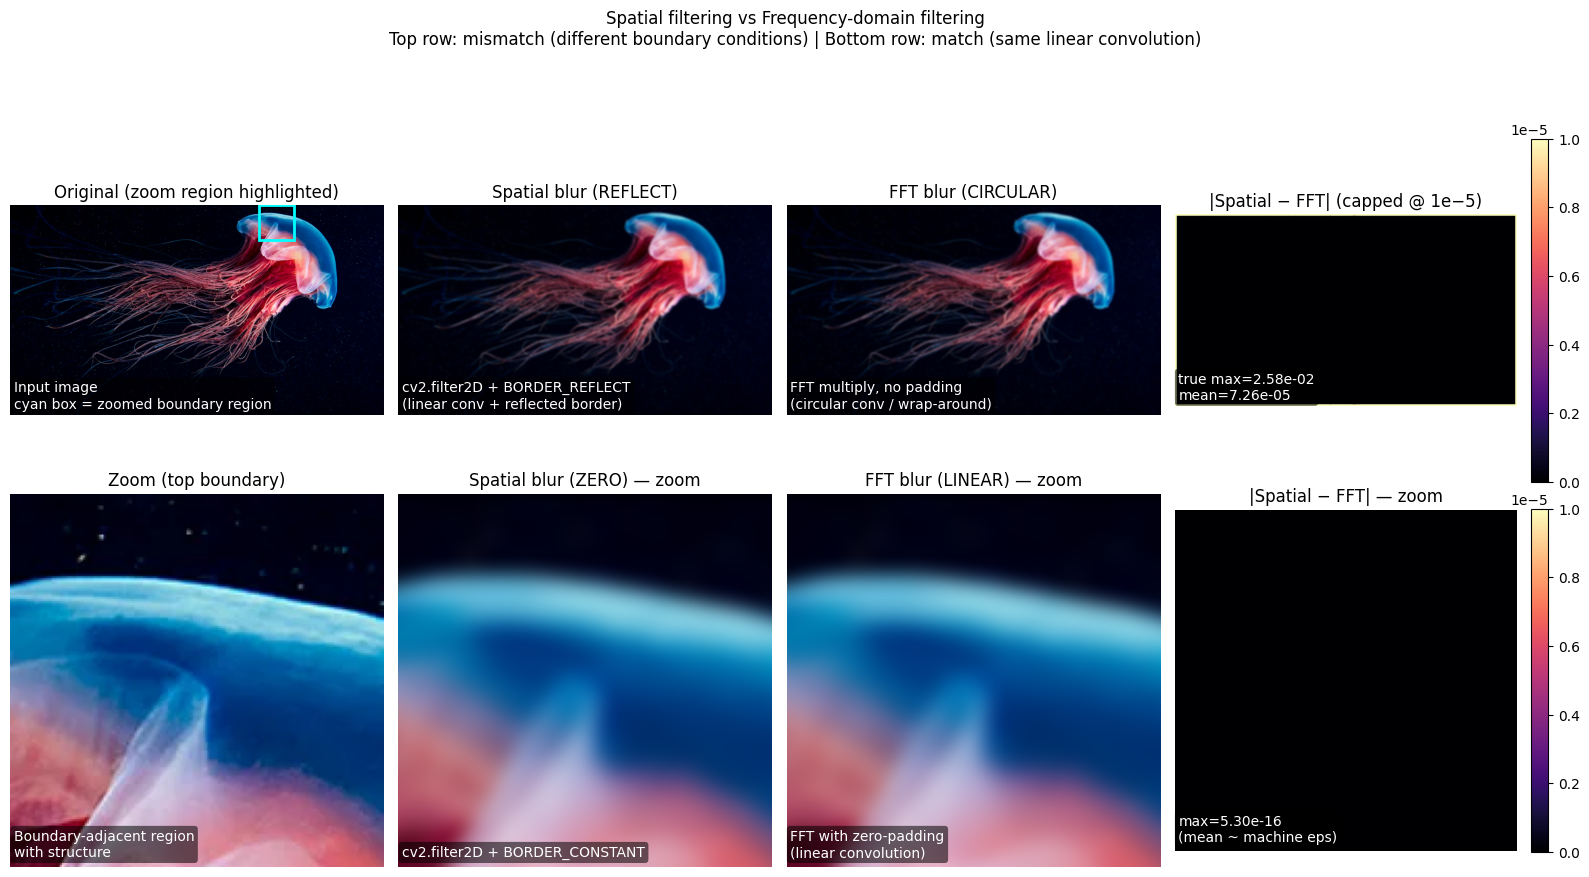

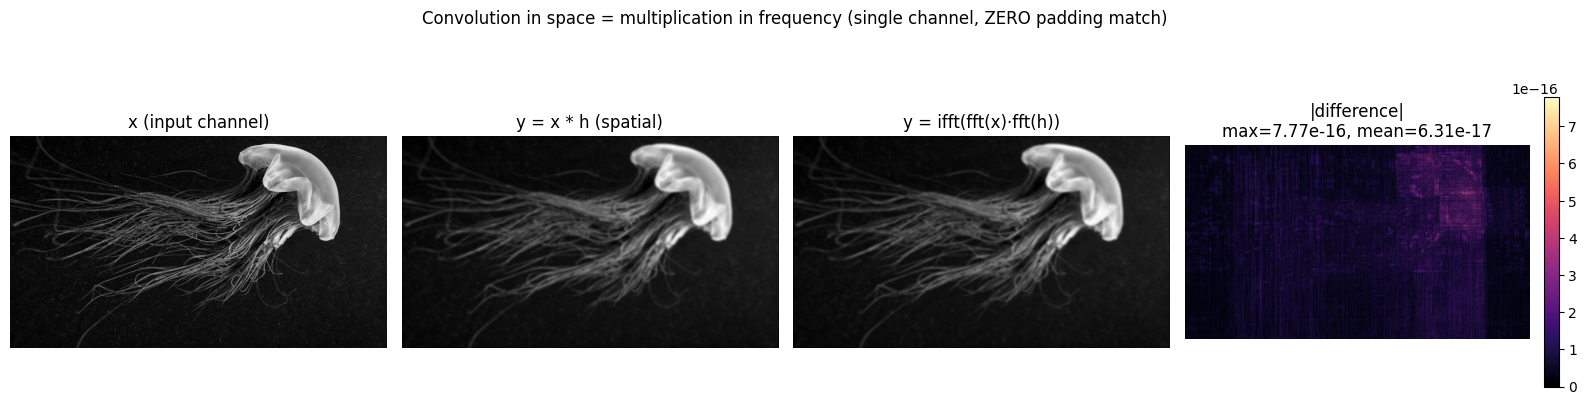

Kernel: size = (21, 21) sum = 1.0
Mismatch case (REFLECT vs CIRCULAR): max = 0.025848326843254537 mean = 7.261462582054993e-05
Match case    (ZERO vs LINEAR)     : max = 5.296689013315851e-16 mean = 5.952781029284624e-17


In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# ============================================================
# UTILITIES
# ============================================================
def gaussian_kernel(size=21, sigma=5.0):
    k1 = cv2.getGaussianKernel(size, sigma)
    return (k1 @ k1.T).astype(np.float64)

def fft_linear_same(image, kernel):
    H, W = image.shape
    kh, kw = kernel.shape

    pad_h = H + kh - 1
    pad_w = W + kw - 1

    Fk = np.fft.fft2(kernel, s=(pad_h, pad_w))
    Fi = np.fft.fft2(image,  s=(pad_h, pad_w))
    full = np.fft.ifft2(Fi * Fk).real

    y0 = kh // 2
    x0 = kw // 2
    return full[y0:y0 + H, x0:x0 + W]

def fft_circular(image, kernel):
    H, W = image.shape
    kh, kw = kernel.shape

    Fk = np.fft.fft2(kernel, s=(H, W))
    Fi = np.fft.fft2(image)
    y = np.fft.ifft2(Fi * Fk).real

    y = np.roll(y, -(kh // 2), axis=0)
    y = np.roll(y, -(kw // 2), axis=1)
    return y

def per_channel_stats(d):
    mx = d.max(axis=(0, 1))
    mean = d.mean(axis=(0, 1))
    return mx, mean

def annotate(ax, text):
    ax.text(
        0.01, 0.02, text,
        transform=ax.transAxes,
        fontsize=10,
        va="bottom", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.55, edgecolor="none"),
        color="white"
    )

# ============================================================
# LOAD IMAGE
# ============================================================
img_bgr = cv2.imread("jelly.jpg", cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError("Could not read 'jelly.jpg'.")

img_bgr = img_bgr.astype(np.float64) / 255.0
img_rgb = cv2.cvtColor(img_bgr.astype(np.float32), cv2.COLOR_BGR2RGB)

kernel = gaussian_kernel(21, 5.0)
kernel_sum = float(kernel.sum())

# ============================================================
# COMPUTE FILTERS
# ============================================================
sp_reflect = np.zeros_like(img_bgr)
sp_zero    = np.zeros_like(img_bgr)
fft_circ   = np.zeros_like(img_bgr)
fft_lin    = np.zeros_like(img_bgr)

for c in range(3):
    ch = img_bgr[..., c]
    sp_reflect[..., c] = cv2.filter2D(ch, cv2.CV_64F, kernel, borderType=cv2.BORDER_REFLECT)
    sp_zero[..., c]    = cv2.filter2D(ch, cv2.CV_64F, kernel, borderType=cv2.BORDER_CONSTANT)
    fft_circ[..., c]   = fft_circular(ch, kernel)
    fft_lin[..., c]    = fft_linear_same(ch, kernel)

diff_A = np.abs(sp_reflect - fft_circ)
diff_B = np.abs(sp_zero    - fft_lin)

diffA_show = diff_A.mean(axis=2)
diffB_show = diff_B.mean(axis=2)

mxA = float(diffA_show.max())
mxB = float(diffB_show.max())

mxA_ch, meanA_ch = per_channel_stats(diff_A)
mxB_ch, meanB_ch = per_channel_stats(diff_B)

# ============================================================
# ZOOM REGION (top boundary, ~2/3 across)
# ============================================================
H, W, _ = img_rgb.shape
z = 180
r0 = 0
c0 = int(2 * W / 3)

def crop(im):
    return im[r0:r0 + z, c0:c0 + z]

img_zoom   = crop(img_rgb)
zero_zoom  = crop(cv2.cvtColor(sp_zero.astype(np.float32), cv2.COLOR_BGR2RGB))
lin_zoom   = crop(cv2.cvtColor(fft_lin.astype(np.float32), cv2.COLOR_BGR2RGB))
diffA_zoom = crop(diffA_show)
diffB_zoom = crop(diffB_show)

# ============================================================
# ERROR SCALE CONTROL
#   Top FIGURE only (entire Figure 1): cap at 1e-5
# ============================================================
vmax_fig1 = 1e-5

# ============================================================
# FIGURE 1
# ============================================================
plt.figure(figsize=(16, 9))
plt.suptitle(
    "Spatial filtering vs Frequency-domain filtering\n"
    "Top row: mismatch (different boundary conditions) | Bottom row: match (same linear convolution)",
    y=0.98
)

# --- Original with zoom box ---
ax = plt.subplot(2, 4, 1)
ax.imshow(img_rgb)
ax.axis("off")
ax.set_title("Original (zoom region highlighted)")

rect = patches.Rectangle(
    (c0, r0), z, z,
    linewidth=2,
    edgecolor="cyan",
    facecolor="none"
)
ax.add_patch(rect)

annotate(ax, "Input image\ncyan box = zoomed boundary region")

# --- Spatial REFLECT ---
ax = plt.subplot(2, 4, 2)
ax.imshow(cv2.cvtColor(sp_reflect.astype(np.float32), cv2.COLOR_BGR2RGB))
ax.axis("off")
ax.set_title("Spatial blur (REFLECT)")
annotate(ax, "cv2.filter2D + BORDER_REFLECT\n(linear conv + reflected border)")

# --- FFT CIRCULAR ---
ax = plt.subplot(2, 4, 3)
ax.imshow(cv2.cvtColor(fft_circ.astype(np.float32), cv2.COLOR_BGR2RGB))
ax.axis("off")
ax.set_title("FFT blur (CIRCULAR)")
annotate(ax, "FFT multiply, no padding\n(circular conv / wrap-around)")

# --- Difference A (capped scale) ---
ax = plt.subplot(2, 4, 4)
imA = ax.imshow(diffA_show, cmap="magma", vmin=0.0, vmax=vmax_fig1)
ax.axis("off")
ax.set_title("|Spatial − FFT| (capped @ 1e−5)")
annotate(ax, f"true max={mxA:.2e}\nmean={float(diffA_show.mean()):.2e}")
plt.colorbar(imA, ax=ax, fraction=0.046, pad=0.04)

# --- Zoom ---
ax = plt.subplot(2, 4, 5)
ax.imshow(img_zoom)
ax.axis("off")
ax.set_title("Zoom (top boundary)")
annotate(ax, "Boundary-adjacent region\nwith structure")

# --- Spatial ZERO ---
ax = plt.subplot(2, 4, 6)
ax.imshow(zero_zoom)
ax.axis("off")
ax.set_title("Spatial blur (ZERO) — zoom")
annotate(ax, "cv2.filter2D + BORDER_CONSTANT")

# --- FFT LINEAR ---
ax = plt.subplot(2, 4, 7)
ax.imshow(lin_zoom)
ax.axis("off")
ax.set_title("FFT blur (LINEAR) — zoom")
annotate(ax, "FFT with zero-padding\n(linear convolution)")

# --- Difference B (same capped scale for visual consistency) ---
ax = plt.subplot(2, 4, 8)
imB = ax.imshow(diffB_zoom, cmap="magma", vmin=0.0, vmax=vmax_fig1)
ax.axis("off")
ax.set_title("|Spatial − FFT| — zoom")
annotate(ax, f"max={mxB:.2e}\n(mean ~ machine eps)")
plt.colorbar(imB, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

# ============================================================
# FIGURE 2: CONVOLUTION THEOREM (SINGLE CHANNEL)
# ============================================================
x = img_bgr[..., 0]
h = kernel

pad_h = x.shape[0] + h.shape[0] - 1
pad_w = x.shape[1] + h.shape[1] - 1

X = np.fft.fft2(x, s=(pad_h, pad_w))
Hf = np.fft.fft2(h, s=(pad_h, pad_w))
Y = np.fft.ifft2(X * Hf).real

y_fft = Y[h.shape[0]//2:h.shape[0]//2 + x.shape[0],
          h.shape[1]//2:h.shape[1]//2 + x.shape[1]]

y_sp = cv2.filter2D(x, cv2.CV_64F, h, borderType=cv2.BORDER_CONSTANT)
d = np.abs(y_sp - y_fft)

plt.figure(figsize=(16, 4))
plt.suptitle("Convolution in space = multiplication in frequency (single channel, ZERO padding match)")

ax = plt.subplot(1, 4, 1)
ax.imshow(x, cmap="gray")
ax.axis("off")
ax.set_title("x (input channel)")

ax = plt.subplot(1, 4, 2)
ax.imshow(y_sp, cmap="gray")
ax.axis("off")
ax.set_title("y = x * h (spatial)")

ax = plt.subplot(1, 4, 3)
ax.imshow(y_fft, cmap="gray")
ax.axis("off")
ax.set_title("y = ifft(fft(x)·fft(h))")

ax = plt.subplot(1, 4, 4)
im = ax.imshow(d, cmap="magma")
ax.axis("off")
ax.set_title(f"|difference|\nmax={float(d.max()):.2e}, mean={float(d.mean()):.2e}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

# ============================================================
# NUMERIC SUMMARY
# ============================================================
print("Kernel: size =", kernel.shape, "sum =", kernel_sum)
print("Mismatch case (REFLECT vs CIRCULAR): max =", mxA, "mean =", float(diffA_show.mean()))
print("Match case    (ZERO vs LINEAR)     : max =", mxB, "mean =", float(diffB_show.mean()))


**Figure A. Spatial-domain vs frequency-domain image filtering.**  
**Top row (mismatch case):** The original image is blurred using a Gaussian filter in the spatial domain with reflected boundaries (Spatial blur, REFLECT) and in the frequency domain using FFT multiplication without padding (FFT blur, CIRCULAR). The difference image (|Spatial − FFT|) highlights discrepancies caused by circular convolution and wrap-around at the image boundaries.  
**Bottom row (match case):** A zoomed view of the top-left corner emphasizes boundary behavior. Spatial blurring with zero padding (Spatial blur, ZERO) is compared to an FFT-based implementation with explicit zero padding and cropping (FFT blur, LINEAR). The corresponding difference image shows errors at machine precision, demonstrating that spatial convolution and frequency-domain multiplication are equivalent when the same linear convolution and boundary conditions are used.

**Figure B. Demonstration of the convolution theorem (single channel).**  
From left to right: the input image channel *x*; the result of spatial-domain convolution with a Gaussian kernel (*y = x ∗ h*); the result obtained by multiplying the Fourier transforms of the image and kernel followed by inverse FFT (*y = ifft(fft(x) · fft(h))*), using zero padding to implement linear convolution; and the absolute difference between the two outputs. The difference is at machine precision (max ≈ 7.8 × 10⁻¹⁶), confirming that convolution in the spatial domain is equivalent to multiplication in the frequency domain when the same linear convolution and padding are used.



# Appendix — Spatial vs Frequency-Domain Filtering (Explanation)

This appendix explains **what each panel in the figure represents** and **why the results differ or match**, without introducing new theory beyond what is required to interpret the visuals.

The main claim being illustrated is:

Convolution performed in the spatial domain produces the same result as multiplication in the frequency domain **only when both implement the same linear convolution**, including boundary handling.

---

## A. Top Row — Mismatch Case (Different Boundary Conditions)

### A1. Original
The unfiltered input image.  
All other panels are derived from this image.

Purpose:  
Provides the reference content for all comparisons.

---

### A2. Spatial blur (REFLECT)
Gaussian blur applied using OpenCV’s `filter2D` with `BORDER_REFLECT`.

What this means:
- Linear convolution
- Image is extended beyond its boundaries by reflection
- No wrap-around artifacts

Purpose:  
Represents a common and reasonable spatial-domain filtering choice.

---

### A3. FFT blur (CIRCULAR)
Gaussian blur applied via FFT multiplication **without padding**.

What this means:
- FFT assumes the image is periodic
- Left/right and top/bottom edges wrap around
- This is circular convolution

Purpose:  
Shows the result of naïvely applying FFT-based filtering.

---

### A4. |Spatial − FFT| (shared scale)
Absolute difference between A2 and A3.

What this shows:
- Differences concentrate near image boundaries
- Magnitude reflects real disagreement, not numerical noise

Purpose:  
Demonstrates that spatial filtering and FFT filtering are **not equivalent** when boundary conditions differ.

---

## B. Bottom Row — Match Case (Same Linear Convolution)

### B1. Zoom (top-left)
A zoomed view of a corner of the original image.

Purpose:  
Boundary effects are most visible near edges; this region is where disagreement would appear if present.

---

### B2. Spatial blur (ZERO) — zoom
Gaussian blur using `filter2D` with `BORDER_CONSTANT` (zero padding).

What this means:
- Linear convolution
- Outside-image values are treated as zero

Purpose:  
Defines a spatial operation that can be exactly reproduced in the frequency domain.

---

### B3. FFT blur (LINEAR) — zoom
FFT-based blur with:
- explicit zero padding
- multiplication in the frequency domain
- cropping back to original size

What this means:
- True linear convolution
- Same operation as B2, implemented via FFT

Purpose:  
Frequency-domain equivalent of the spatial blur in B2.

---

### B4. |Spatial − FFT| — zoom (shared scale)
Absolute difference between B2 and B3.

What this shows:
- Maximum error on the order of 1e−16
- Differences are at machine precision

Purpose:  
Confirms numerical equivalence between spatial convolution and frequency-domain multiplication when the same linear convolution is implemented.

---

## C. Interpretation Summary

- The mismatch case differs because it compares **linear convolution with reflected boundaries** to **circular convolution**.
- The match case aligns boundary handling and convolution type, resulting in numerical identity.
- The FFT itself is not the source of error; boundary conditions are.

---

# Figure Legend

**Original**  
Input image.

**Spatial blur (REFLECT)**  
Linear convolution in the spatial domain with reflected boundaries.

**FFT blur (CIRCULAR)**  
Frequency-domain filtering without padding (circular convolution).

**|Spatial − FFT| (shared scale)**  
Absolute per-pixel difference between spatial and FFT results.

**Zoom (top-left)**  
Magnified corner region where boundary effects are strongest.

**Spatial blur (ZERO)**  
Linear convolution with zero padding.

**FFT blur (LINEAR)**  
Frequency-domain implementation of the same linear convolution.

**|Spatial − FFT| — zoom**  
Difference between matched spatial and FFT results, shown at identical scale.

---

## Final Takeaway

Spatial-domain filtering and frequency-domain filtering produce identical results **only when they implement the same linear convolution**.  
Any visible discrepancy arises from boundary handling, not from the Fourier transform.
